<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-to-test-basic-functionalities" data-toc-modified-id="Notebook-to-test-basic-functionalities-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook to test basic functionalities</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Backtest-of-two-years,-using-2-different-combinations-of-MA-crossover" data-toc-modified-id="Backtest-of-two-years,-using-2-different-combinations-of-MA-crossover-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Backtest of two years, using 2 different combinations of MA crossover</a></span><ul class="toc-item"><li><span><a href="#Performance-of-each-year-individually:" data-toc-modified-id="Performance-of-each-year-individually:-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Performance of each year individually:</a></span></li><li><span><a href="#Performance-of-both-time-periods-together" data-toc-modified-id="Performance-of-both-time-periods-together-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Performance of both time periods together</a></span></li><li><span><a href="#Checking-'Strat_position'-and-'Costs'-of-last-days-of-year-1,-and-first-days-of-year-2" data-toc-modified-id="Checking-'Strat_position'-and-'Costs'-of-last-days-of-year-1,-and-first-days-of-year-2-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Checking 'Strat_position' and 'Costs' of last days of year 1, and first days of year 2</a></span></li></ul></li><li><span><a href="#Walk-forward-optimization." data-toc-modified-id="Walk-forward-optimization.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Walk forward optimization.</a></span></li><li><span><a href="#Calculate-performance-metrics" data-toc-modified-id="Calculate-performance-metrics-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Calculate performance metrics</a></span></li><li><span><a href="#Save-results" data-toc-modified-id="Save-results-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Save results</a></span></li></ul></li></ul></div>

# Notebook to test basic functionalities

### Imports

In [1]:
# Settings for notebook visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
from IPython.core.display import HTML
HTML("""<style>.output_png img {display: block;margin-left: auto;margin-right: auto;text-align: center;vertical-align: middle;} </style>""")

In [2]:
# Necessary imports
import os
import numpy as np
import pandas as pd
import matplotlib as plt
import quantstats as qs
from datetime import datetime, timedelta
from tqdm.auto import tqdm, trange
print("Libraries imported correctly")

Libraries imported correctly


In [3]:
# Other settings

# Settings for plot visualization
plt.style.use('seaborn-darkgrid')

#plt.rcParams.keys()
plt.rcParams['figure.dpi'] = 200
plt.rcParams["figure.figsize"] = (12,3.5) #(12,5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linewidth'] = 0.4
#plt.rcParams['xtick.label.allignment'] = 'center'

plt.rcParams['xtick.bottom'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True

plt.rcParams['lines.linewidth'] = 1.2
#plt.rcParams['lines.markersize'] = 0.5
plt.rcParams['patch.edgecolor'] = 'k' # Legend border 
plt.rcParams['legend.facecolor'] = 'w'
plt.rcParams["legend.frameon"] = True

np.set_printoptions(edgeitems=40, linewidth=1000)

pd.set_option("display.precision", 6)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#print("Notebook parameters set correctly")

In [4]:
os.chdir("/Users/Sergio/Documents/Master_QF/Thesis/Code/Algorithmic Strategies")
%run Functions.ipynb
%run Plots.ipynb
%run Metrics.ipynb

### Data

In [5]:
ini_equity_default = 100
commision_default = 2/130000 + 12.5/130000 #0.000111538462, around 0.011..% of the equity

Close  Market_daily_ret
Date                                     
2020-12-24  3703.060059          0.003537
2020-12-28  3735.360107          0.008723
2020-12-29  3727.040039         -0.002227
2020-12-30  3732.040039          0.001342
2020-12-31  3756.070068          0.006439

<AxesSubplot:title={'center':'SP500'}, xlabel='Date'>

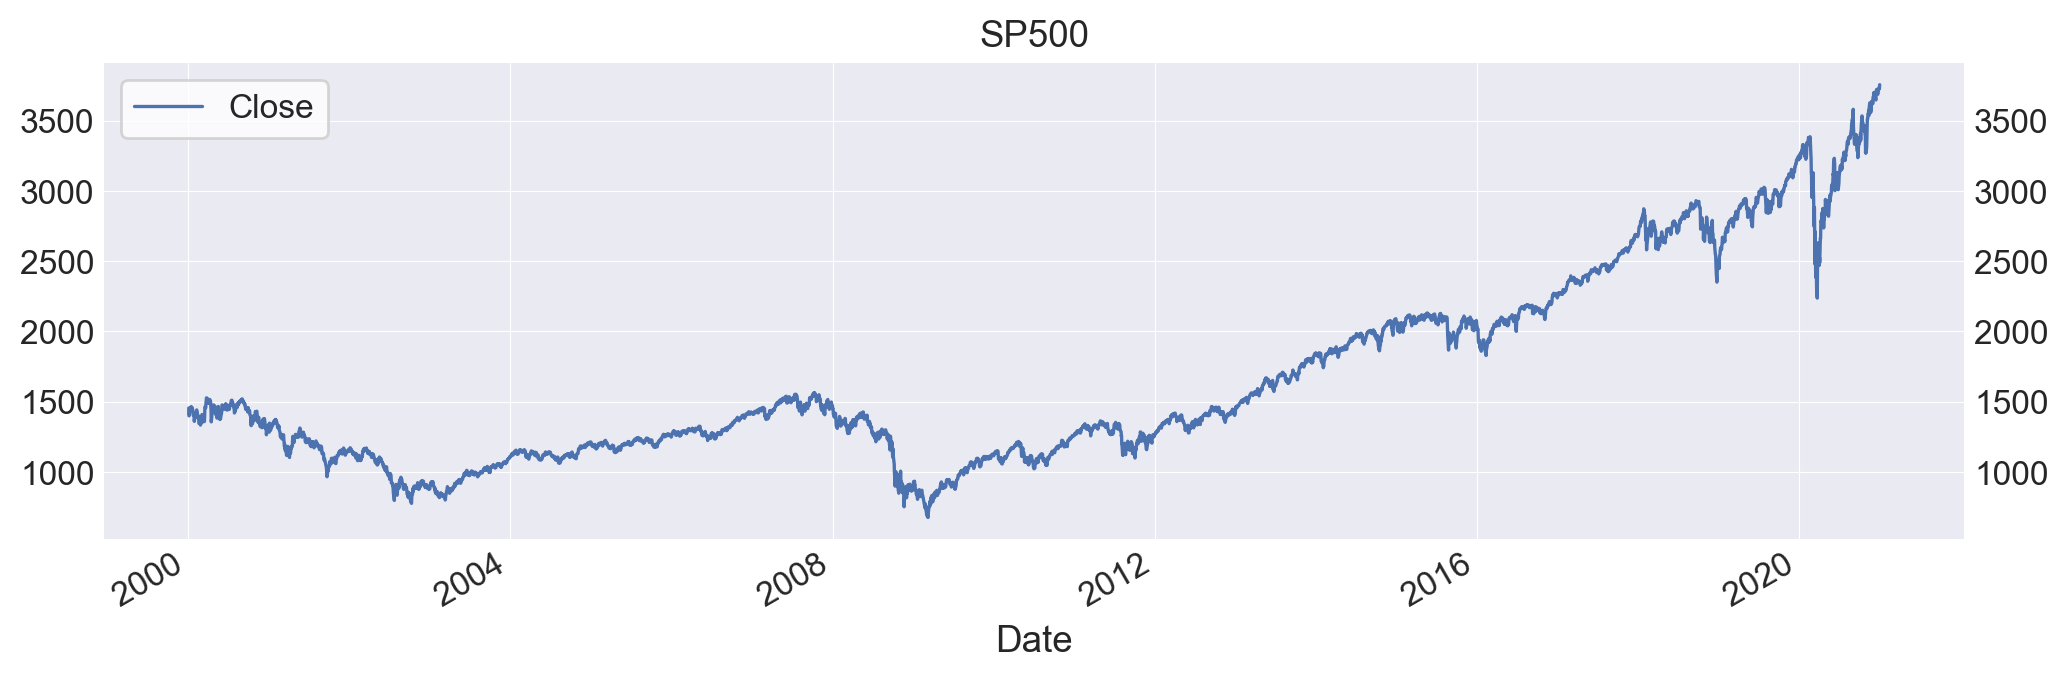

In [6]:
%run Functions.ipynb

#data = get_sp500_data(from_local_file=False, save_to_file=True)
data = get_sp500_data(from_local_file=True, save_to_file=False)
data = data[['Open', 'Close']]

data['Market_daily_ret'] = data['Close'].pct_change().fillna((data['Close']-data['Open'])/data['Open'])
data = data.loc['2000':'2020' ,['Close', 'Market_daily_ret']]

data.tail()
data['Close'].plot(title='SP500', legend=True)

## Backtest of two years, using 2 different combinations of MA crossover

This is useful to see the result of doing two backtests with different parameters on two different periods. Finally those periods are merged together.


This is a backtest from 2018-01-01 to 2019-12-31. Each year will have a different combination of MAs.  
- 2018: will be long all the time.  
- 2019: will use fast_ma=75 and slow_ma=200.

1st year finishes with a long position, and 2nd year starts with a neutral position. This will be useful to see again that 'Strat_position' and 'Costs' are calculated and added correctly to the overall performance.

In [7]:
date_fmt = '%Y-%m-%d'
first_day = datetime.strptime('2018-01-01', date_fmt)
last_day = datetime.strptime('2019-12-31', date_fmt)
fast_ma = 75
slow_ma = 200

### Performance of each year individually:

The purpose of each plots is:  
1. See performance of Market and Long only strategy during 2018. 'Strat_position' and  'Long_only' are always 1.  
2. See performance of Market and MA (75-200) strategy during 2019. See how 'Strat_position' comes from 0 and changes to 1 on the first day.

Strategy: buy_and_hold()
Period: 2018-01-02 to 2018-12-31
	Overall return of SP500: -6.24 %. IR of SP500: -0.37
	Overall return of strategy: -6.24 %. IR strategy: -0.37
Strategy: ma_crossover(75-200)
Period: 2019-01-02 to 2019-12-31
	Overall return of SP500: +28.88 %. IR of SP500: 2.32
	Overall return of strategy: +10.34 %. IR strategy: 1.00


Close  Market_daily_ret  Strat_daily_ret  Strat_position     Costs  Long_only  Market_cum_ret  Strat_cum_ret
Date                                                                                                                          
2018-01-02  2695.810059          0.008303         0.008191             1.0  0.011154        1.0      100.830336      100.81909

Close  Market_daily_ret  Strat_daily_ret  Strat_position  Costs  Long_only  Market_cum_ret  Strat_cum_ret
Date                                                                                                                       
2018-12-31  2506.850098          0.008492         0.008492             1.0    0.0        1.0        93.76274      93.752282

Close  Market_daily_ret  Strat_daily_ret  Strat_position     Costs  Long_only  Market_cum_ret  Strat_cum_ret
Date                                                                                                                          
2019-01-02  2510.030029          0.001268        -0.000112             0.0  0.010458        0.0       93.881678      93.752282

Close  Market_daily_ret  Strat_daily_ret  Strat_position  Costs  Long_only  Market_cum_ret  Strat_cum_ret
Date                                                                                                                       
2019-12-31  3230.780029          0.002946         0.002946             1.0    0.0        0.0       120.83961     103.462026

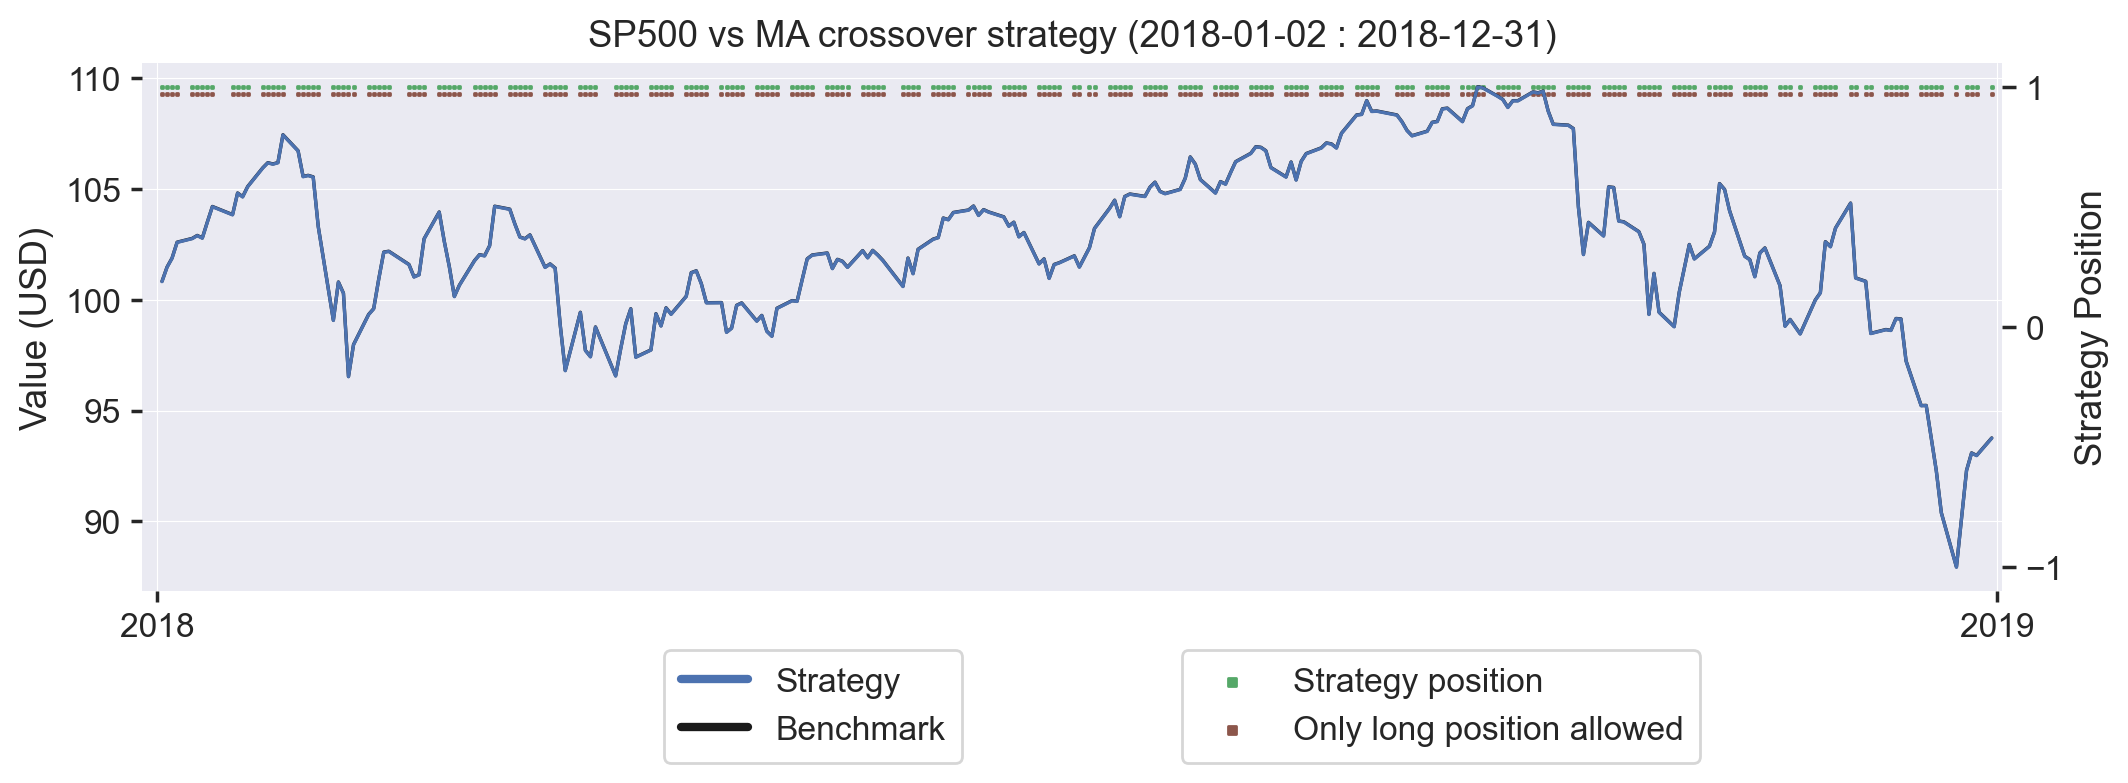

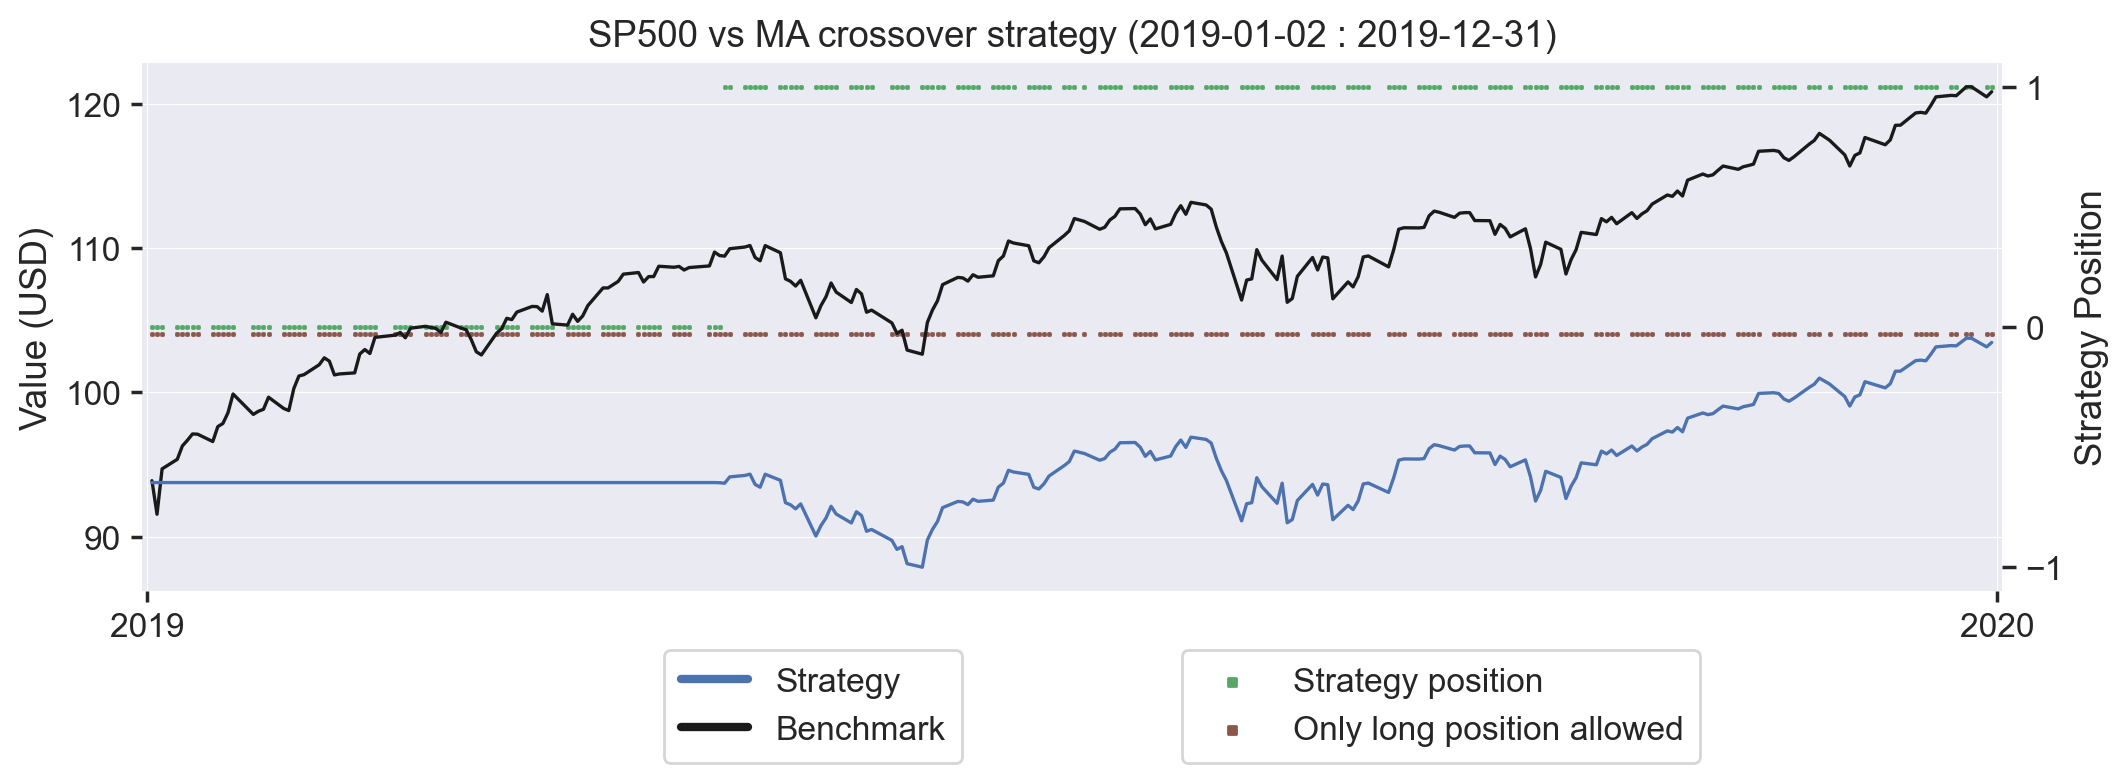

In [8]:
%run Functions.ipynb
df = data[first_day:last_day].copy()
commision = commision_default

cols = ['Strat_daily_ret', 'Strat_position', 'Costs', 'Long_only', 'Market_cum_ret', 'Strat_cum_ret']
tmp_df = pd.DataFrame(columns=cols)

df_year_1 = df.loc[str(first_day.year)].copy()
df_year_2 = df.loc[str(last_day.year)].copy()

strategy_1 = buy_and_hold(df_year_1)
strategy_2 = ma_crossover(df_year_2, fast_ma, slow_ma)

#  Year 1
df_year_1 = backtest_print_plot(df_year_1, strategy_1, previous_position=0, commision=commision, with_legend=True)
last_position = df_year_1.loc[df_year_1.index[-1], 'Strat_position'] # Position during the last day
last_equity = df_year_1.loc[df_year_1.index[-1], 'Market_cum_ret']
# last_equity = 100

#  Year 2
df_year_2 = backtest_print_plot(df_year_2, strategy_2, strat_params=(fast_ma, slow_ma), previous_position=last_position, ini_equity=last_equity, commision=commision, with_legend=True)

# Put together both periods
tmp_df = pd.concat([df_year_1, df_year_2], axis=0)

#  Add all obtained columns in the original df
df = pd.concat([df, tmp_df[cols]], axis=1)

# To see details of the output
df[str(df_year_1.index[0].year)].head(1)
df[str(df_year_1.index[0].year)].tail(1)
#last_equity
df[str(df_year_2.index[0].year)].head(1)
df[str(df_year_2.index[0].year)].tail(1)

# df_year_1[['Strat_position', 'Long_only']].plot()
# df_year_1[['Costs']].plot()
# df_year_2[['Costs']].plot()

### Performance of both time periods together

The purpose of each plots is:  
1. Show previous plots concatenated. See that 'Strat_position' and 'Long_only' change properly in the beggining of 2019
2. Subplots to see how the changes in the strategy position affect 'Long_only', 'Strat_position', and 'Costs'

Period: 2018-01-02 to 2019-12-31
	Overall return of SP500: 120.84 %. SR of SP500: 0.71
	Overall return of our strategy: 103.45 %. Sharpe ratio strategy: 0.16


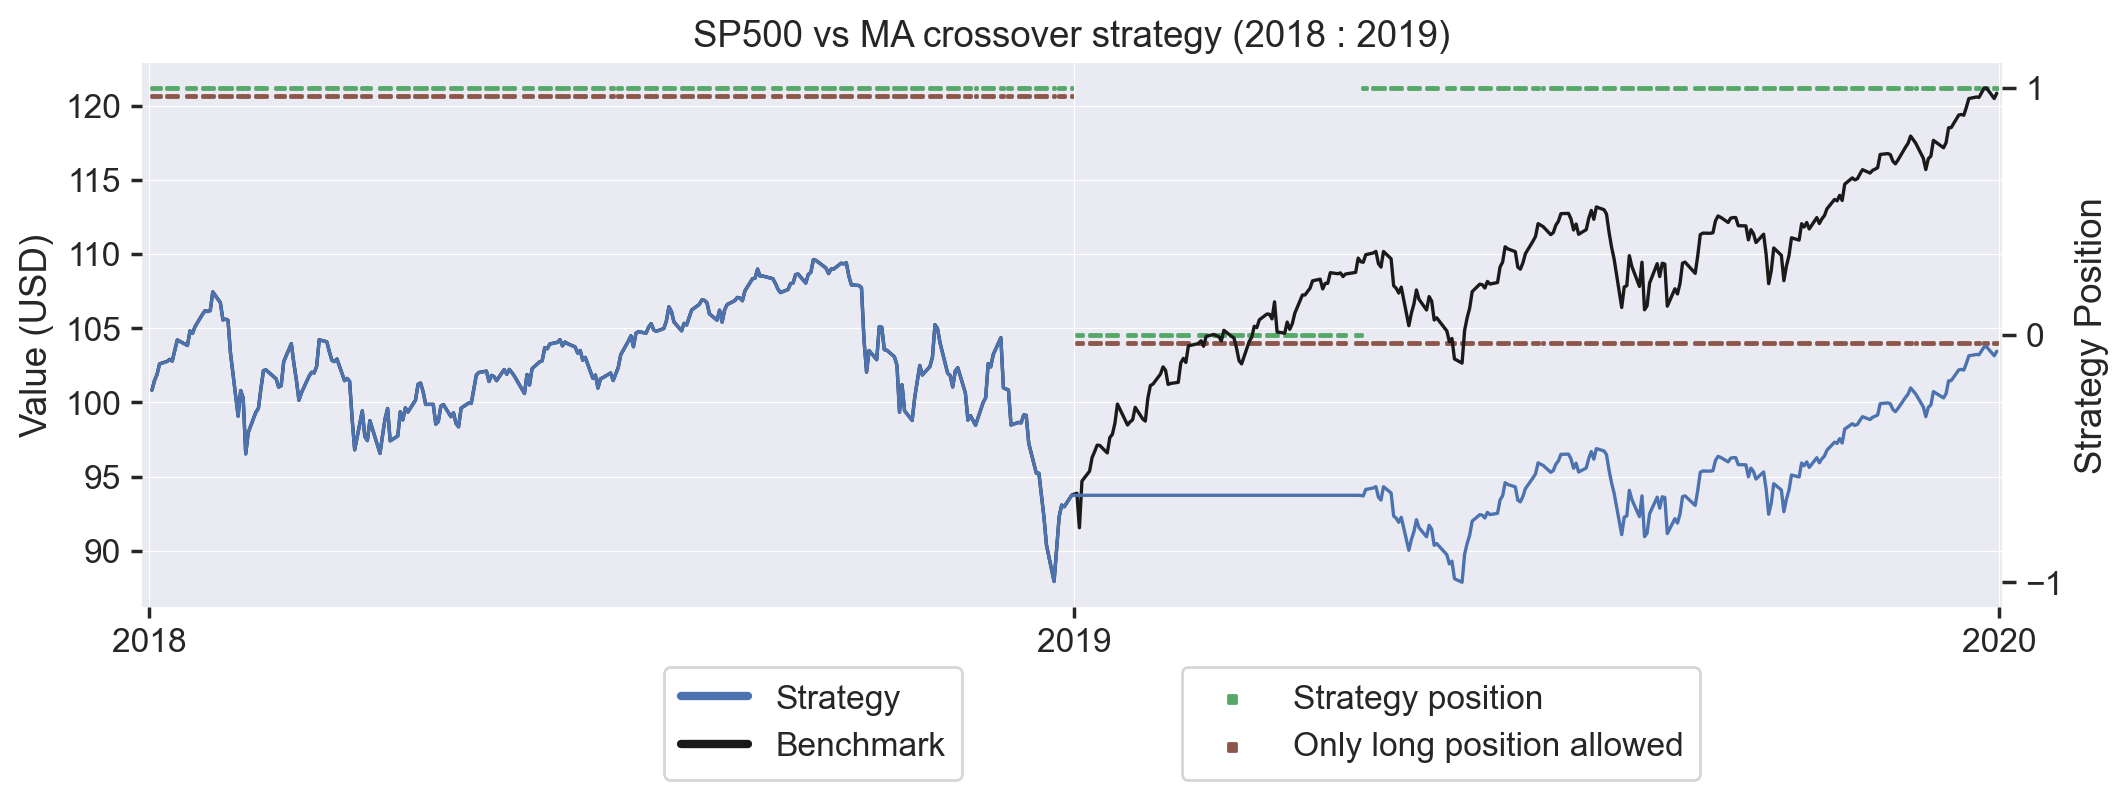

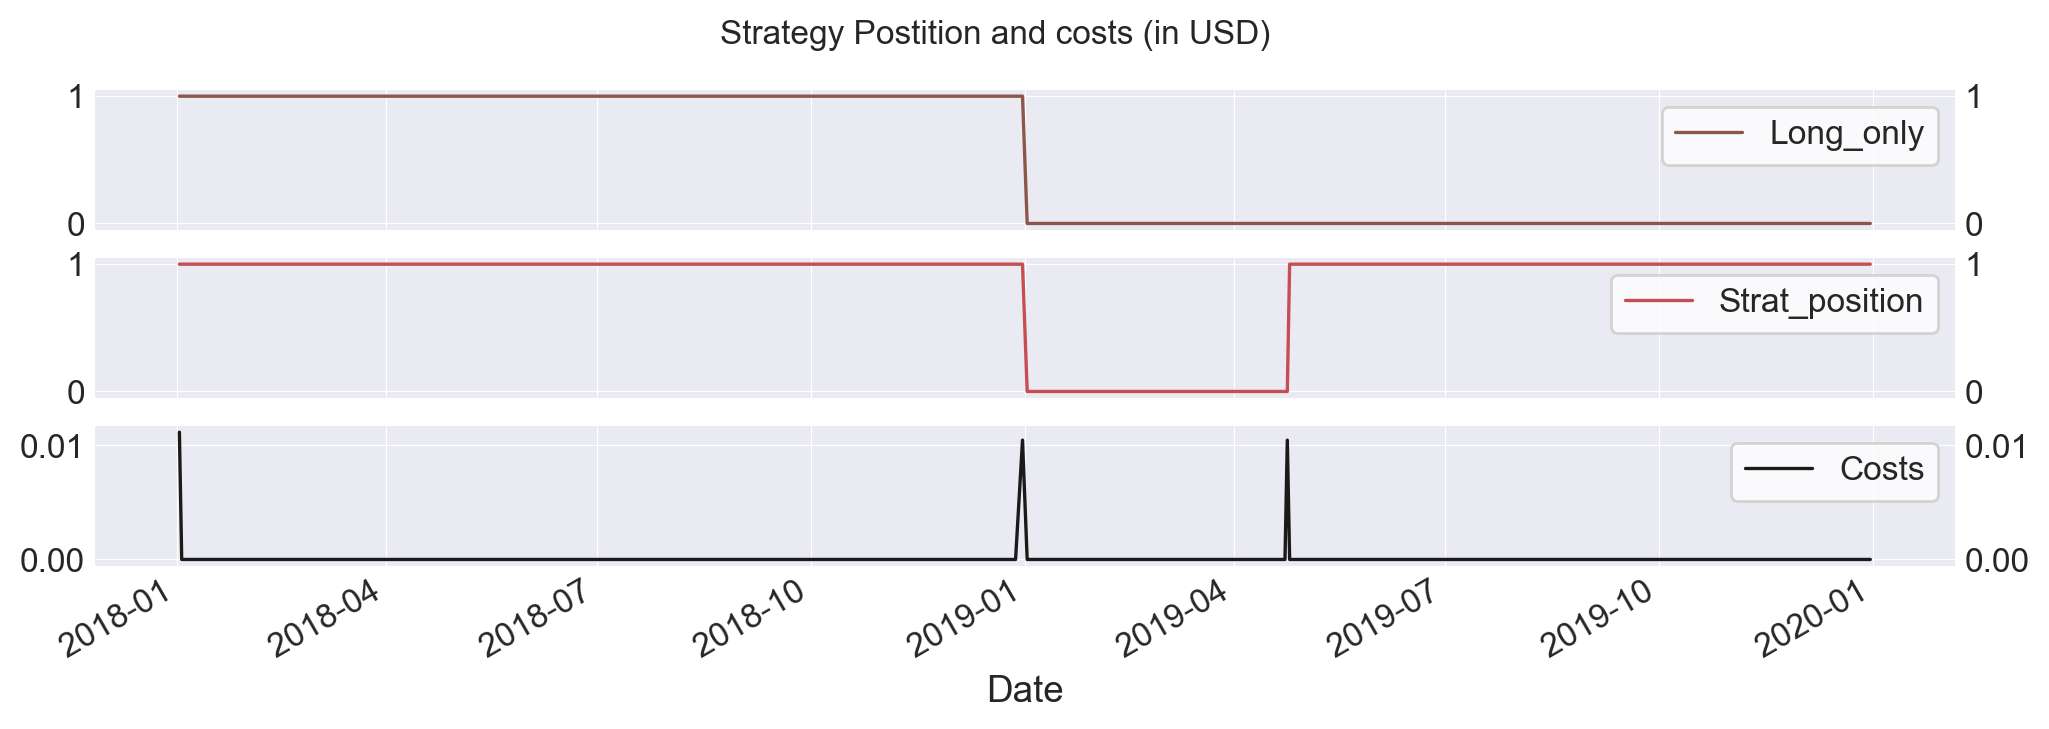

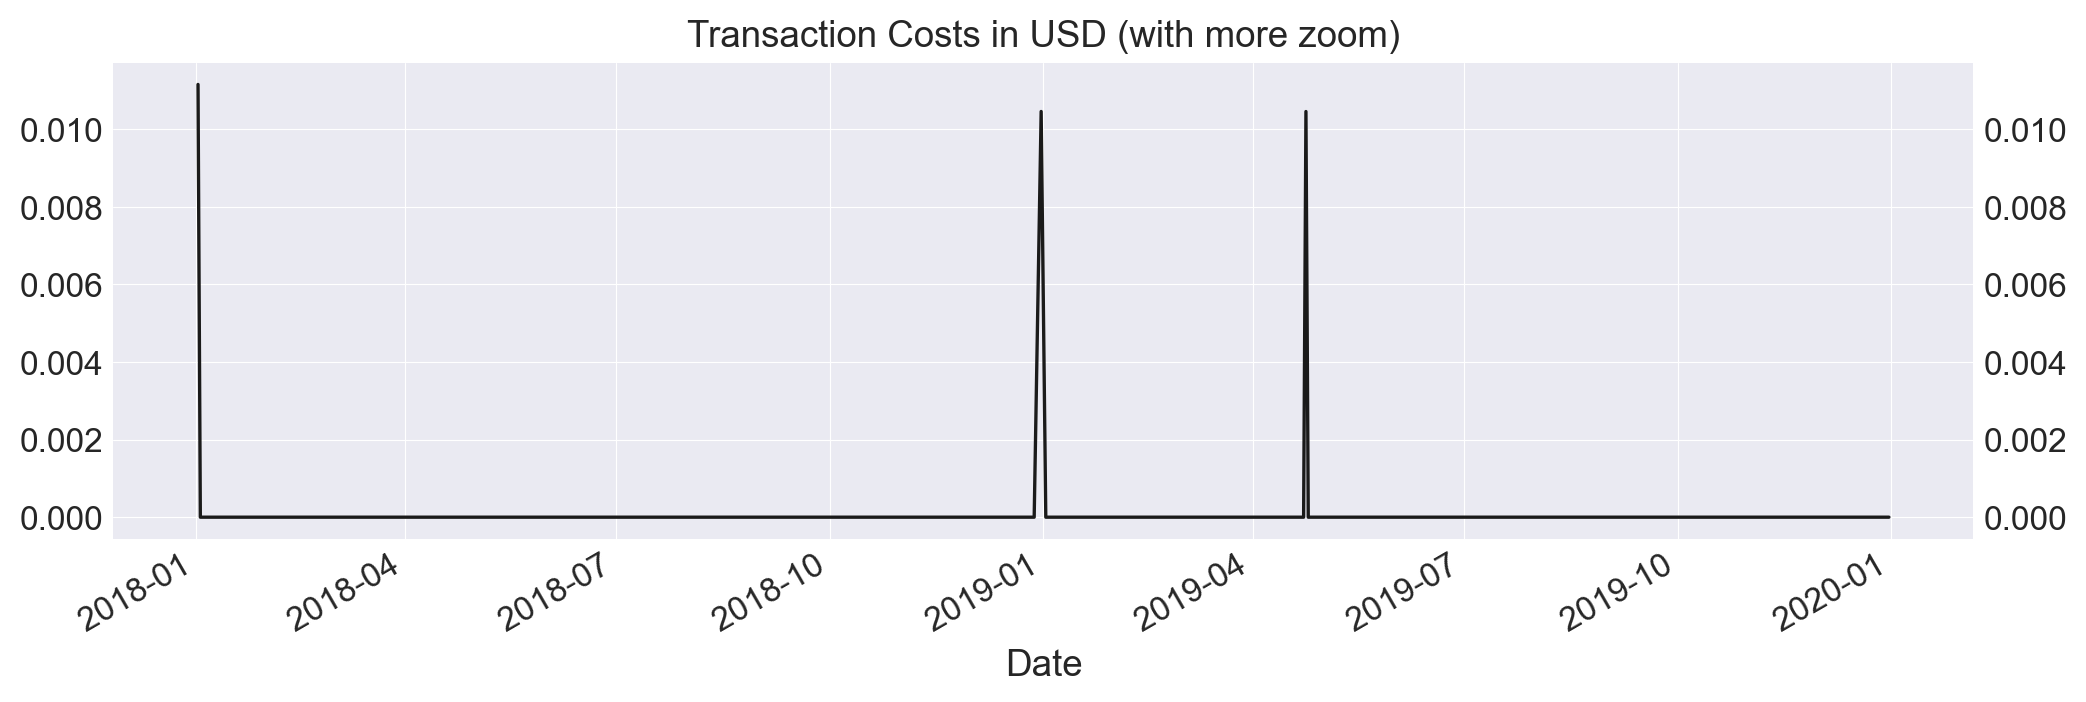

In [9]:
%run Functions.ipynb

results_df = prepare_oos_df(df.loc[first_day:last_day].copy(), commision=commision_default)
show_oos_plot(results_df, with_legend=True)

print("Period: {:%Y-%m-%d} to {:%Y-%m-%d}".format(results_df.index[0], results_df.index[-1]))
print("\tOverall return of SP500: {:.2f} %. SR of SP500: {:.2f}".format(results_df['Market_cum_ret'][-1], results_df['Market_daily_ret'].sharpe()))
print("\tOverall return of our strategy: {:.2f} %. Sharpe ratio strategy: {:.2f}".format(results_df['Strat_cum_ret'][-1], results_df['Strat_cum_ret'].sharpe()))

cols = ['Long_only', 'Strat_position', 'Costs']
results_df[cols].plot(subplots=True, title='Strategy Postition and costs (in USD)', color=('tab:brown', 'r', 'k'));
plt.show()
results_df['Costs'].plot(title='Transaction Costs in USD (with more zoom)', color=('k'));

### Checking 'Strat_position' and 'Costs' of last days of year 1, and first days of year 2

The purpose of this section is to check how 'Strat_position' and 'Costs' have changed in the dataframe. More specifically, on dates:
1. Start of backtesting period: 'Costs' to open the position for the following day and its effect on 'Strat_cum_ret' should be shown
   
2. First days of 2019. Since we need to change the 'Strat_position' from long to being neutral, 'Costs' should be shown for closing the position. We can also see the change in 'Long_only' from 1 to 0.
3. At the end of 2019-04-23, there is an upward MA cross. 'Strat_position' and 'Costs' should change accordingly.

In [10]:
def style_original_value(x):
    color = 'background-color: darkorange'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.loc['2018-12-31', ['Strat_daily_ret', 'Strat_position', 'Costs', 'Strat_cum_ret']] = color
    df1.loc['2019-01-02', ['Strat_daily_ret', 'Costs', 'Strat_cum_ret']] = color

    return df1

def style_fixed_value(x):
    color = 'background-color: green'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.loc['2018-12-31', ['Strat_daily_ret', 'Strat_position', 'Costs', 'Strat_cum_ret']] = color
    df1.loc['2019-01-02', ['Strat_daily_ret', 'Costs', 'Strat_cum_ret']] = color
    return df1

df['2018-12-28':'2019-01-02'].style.apply(style_original_value, axis=None)

results_df['2018-12-28':'2019-01-02'].style.apply(style_fixed_value, axis=None)

First two days: 
	We can see how we did not enter the market until the end of the first trading day.
	So the only returns from the first day come from transaction costs, that were added when we entered a long position
	Costs = $ 0.5, because commision was set to 0.005 in this test


Close  Market_daily_ret  Strat_daily_ret  Strat_position  Costs  Long_only  Market_cum_ret  Strat_cum_ret
Date                                                                                                                       
2018-01-02  2695.810059          0.008303         0.003262             1.0    0.5        1.0      100.830336     100.326184
2018-01-03  2713.060059          0.006399         0.006399             1.0    0.0        1.0      101.475531     100.968154

End of first OOS period and beginning of second OOS period:
	Following two dataframes allow to see how the transaction costs from the first day of second year is moved to the last day of the first year.
	(Because we change the position right before the close of the first year)

Original df:


Close  Market_daily_ret  Strat_daily_ret  Strat_position     Costs  Long_only  Market_cum_ret  Strat_cum_ret
Date                                                                                                                          
2018-12-28  2485.739990         -0.001242        -0.001242             1.0  0.000000        1.0       92.973167      92.962797
2018-12-31  2506.850098          0.008492         0.008492             1.0  0.000000        1.0       93.762740      93.752282
2019-01-02  2510.030029          0.001268        -0.000112             0.0  0.010458        0.0       93.881678      93.752282
2019-01-03  2447.889893         -0.024757         0.000000             0.0  0.000000        0.0       91.557475      93.752282

Fixed df:
	We can see how Strat_position and Costs were fixed properly from the original df to the fixed df:
		On 2018-12-31: 
		Costs (in USD) = previous(Strat_cum_ret) * [1+[Market_Daily_ret*previous(Strat_position)]] * commission
		Costs (in USD) = 92.508301 * (1+(0.008492*1.0)) * (0.005) = 0.46647


Close  Market_daily_ret  Strat_daily_ret  Strat_position    Costs  Long_only  Market_cum_ret  Strat_cum_ret
Date                                                                                                                         
2018-12-28  2485.739990         -0.001242        -0.001242             1.0  0.00000        1.0       92.973167      92.508301
2018-12-31  2506.850098          0.008492         0.003450             1.0  0.46647        1.0       93.762740      92.827457
2019-01-02  2510.030029          0.001268         0.000000             0.0  0.00000        0.0       93.881678      92.827457
2019-01-03  2447.889893         -0.024757         0.000000             0.0  0.00000        0.0       91.557475      92.827457

Change of strategy position (at the end of 2019-04-24): 
	There is a MA crossover at the 'Close' of 2019-04-24. A change in Strat_position should be shown, with a cost to be paid at the end of the day
		On 2019-04-24: 
		Costs (in USD) = previous(Strat_cum_ret) * [1+[Market_Daily_ret*previous(Strat_position)]] * commission
		Costs (in USD) = 92.827457 * (1+(-0.002192*0.0)) * (0.005) = 0.464137


Close  Market_daily_ret  Strat_daily_ret  Strat_position     Costs  Long_only  Market_cum_ret  Strat_cum_ret
Date                                                                                                                          
2019-04-22  2907.969971          0.001012         0.000000             0.0  0.000000        0.0      108.765671      92.827457
2019-04-23  2933.679932          0.008841         0.000000             0.0  0.000000        0.0      109.727291      92.827457
2019-04-24  2927.250000         -0.002192        -0.005000             0.0  0.464137        0.0      109.486794      92.363320
2019-04-25  2926.169922         -0.000369        -0.000369             1.0  0.000000        0.0      109.446397      92.329240

Last two days. We can see information about cummulative returns from the benchmark and out strategy. 
	We have NaN in 'Strat_position', because we have not decided a strategy position for the following OOS period



Close  Market_daily_ret  Strat_daily_ret  Strat_position  Costs  Long_only  Market_cum_ret  Strat_cum_ret
Date                                                                                                                       
2019-12-30  3221.290039         -0.005781        -0.005781             1.0    0.0        0.0       120.48466     101.641145
2019-12-31  3230.780029          0.002946         0.002946             1.0    0.0        0.0       120.83961     101.940582

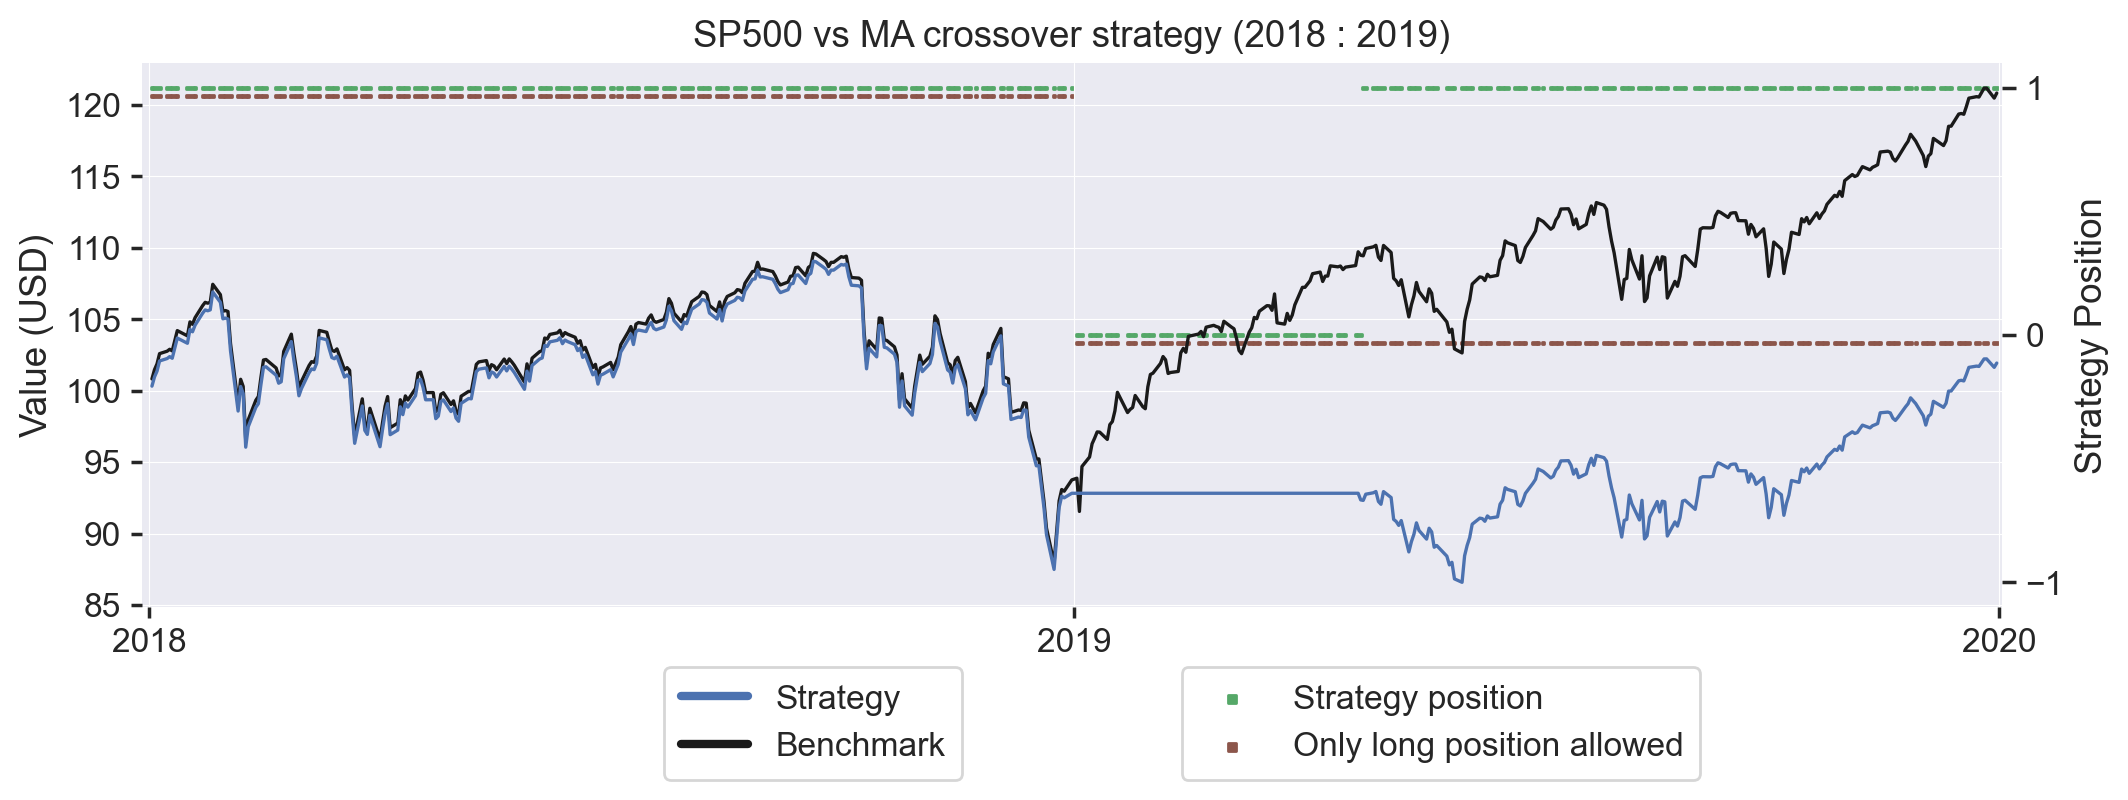

In [11]:
%run Functions.ipynb
results_df = prepare_oos_df(df.loc[first_day:last_day].copy(), commision=0.005)

last_day_2018 = results_df[str(first_day.year)].index[-1]
first_day_2019 = results_df[str(last_day.year)].index[0]

# df contains the output df from both backtests concatenated
# results_df contains the "fixed" df. 

print("First two days: \n\tWe can see how we did not enter the market until the end of the first trading day.\n\t"
        "So the only returns from the first day come from transaction costs, that were added when we entered a long position\n\t"
        "Costs = $ 0.5, because commision was set to 0.005 in this test")
results_df.head(2)

print("End of first OOS period and beginning of second OOS period:\n\t"
        "Following two dataframes allow to see how the transaction costs from the first day of second year is moved to the last day of the first year.\n\t"
        "(Because we change the position right before the close of the first year)\n")

print("Original df:")
df['2018-12-28':'2019-01-03']
print("Fixed df:\n\t"
        "We can see how Strat_position and Costs were fixed properly from the original df to the fixed df:\n\t"
        "\tOn 2018-12-31: \n\t"
        "\tCosts (in USD) = previous(Strat_cum_ret) * [1+[Market_Daily_ret*previous(Strat_position)]] * commission\n\t"
        "\tCosts (in USD) = 92.508301 * (1+(0.008492*1.0)) * (0.005) = 0.46647")
results_df['2018-12-28':'2019-01-03']


print("Change of strategy position (at the end of 2019-04-24): \n\tThere is a MA crossover at the 'Close' of 2019-04-24. A change in Strat_position should be shown,"
        " with a cost to be paid at the end of the day\n\t"
        "\tOn 2019-04-24: \n\t"  
        "\tCosts (in USD) = previous(Strat_cum_ret) * [1+[Market_Daily_ret*previous(Strat_position)]] * commission\n\t"
        "\tCosts (in USD) = 92.827457 * (1+(-0.002192*0.0)) * (0.005) = 0.464137")

results_df.loc['2019-04-22':'2019-04-25']


print("Last two days. We can see information about cummulative returns from the benchmark and out strategy. \n\t"
        "We have NaN in 'Strat_position', because we have not decided a strategy position for the following OOS period\n")
#df.tail(2)
results_df.tail(2)

show_oos_plot(results_df, with_legend=True)

## Walk forward optimization. 

In [8]:
%run Functions.ipynb

memory_len = 0

fast_ma_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
slow_ma_list = [5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260]

# fast_ma_list = [5, 10, 15, 20, 25, 30, 500, 500]
# slow_ma_list = [50, 100, 150, 175, 200, 225, 250, 300]

IS_start = pd.date_range(start='2015-01-01', end='2016-01-01', freq='1YS', closed=None)
IS_end = pd.date_range(start='2017-12-31', end='2018-12-31', freq='1Y', closed=None)
OOS_start = pd.date_range(start='2018-01-01', end='2019-01-01', freq='1YS', closed=None)
OOS_end = pd.date_range(start='2018-12-31', end='2019-12-31', freq='1Y', closed=None)

print(f'Number of combinations: {len(fast_ma_list)*len(slow_ma_list)}\n' 
      f'Length of memory (# of IS periods): {memory_len}')
print_periods(IS_start, IS_end, OOS_start, OOS_end)

num_combinations = len(fast_ma_list)*len(slow_ma_list)
num_is_years = round((IS_end[0]-IS_start[0]).days/365, 0)
num_oos_years = round((OOS_end[0]-OOS_start[0]).days/365, 0)
info_wf_str = (f'Running {num_combinations} backtests on \n'
               f'\t{len(IS_start)} IS rolling windows of {num_is_years} years\n'
               f'\t{len(OOS_start)} OOS rolling windows of {num_oos_years} years\n'
               f'->Total of {num_combinations*len(IS_start)+len(OOS_start)*2} backtests'
               f'\tMemory of {memory_len} IS periods\n'
              )
num_neighbors_matrix = get_num_neighbors_ma_crossover(fast_ma_list, slow_ma_list)
num_neighbors_matrix

Number of combinations: 225
Length of memory (# of IS periods): 0
Number of periods: 2 : 2     2 : 2
	In SAMPLE		OOS
2015-01-01 : 2017-12-31 	 2018-01-01 : 2018-12-31
2016-01-01 : 2018-12-31 	 2019-01-01 : 2019-12-31


array([[ 3.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  3.],
       [ 4.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  5.],
       [nan,  5.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  5.],
       [nan, nan,  6.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  5.],
       [nan, nan,  4.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  5.],
       [nan, nan, nan,  6.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  5.],
       [nan, nan, nan,  5.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  5.],
       [nan, nan, nan,  5.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  5.],
       [nan, nan, nan,  4.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  5.],
       [nan, nan, nan, nan,  6.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  5.],
       [nan, nan, nan, nan,  5.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  5.],
       [nan, nan, nan, nan,  5.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.

Running 225 backtests on 
	2 IS rolling windows of 3.0 years
	2 OOS rolling windows of 1.0 years
->Total of 454 backtests	Memory of 0 IS periods



Best In-sample performance: 
Strategy: buy_and_hold()
Period: 2015-01-02 to 2017-12-29
	Overall return of SP500: +29.86 %. IR of SP500: 0.74
	Overall return of strategy: +29.86 %. IR strategy: 0.74


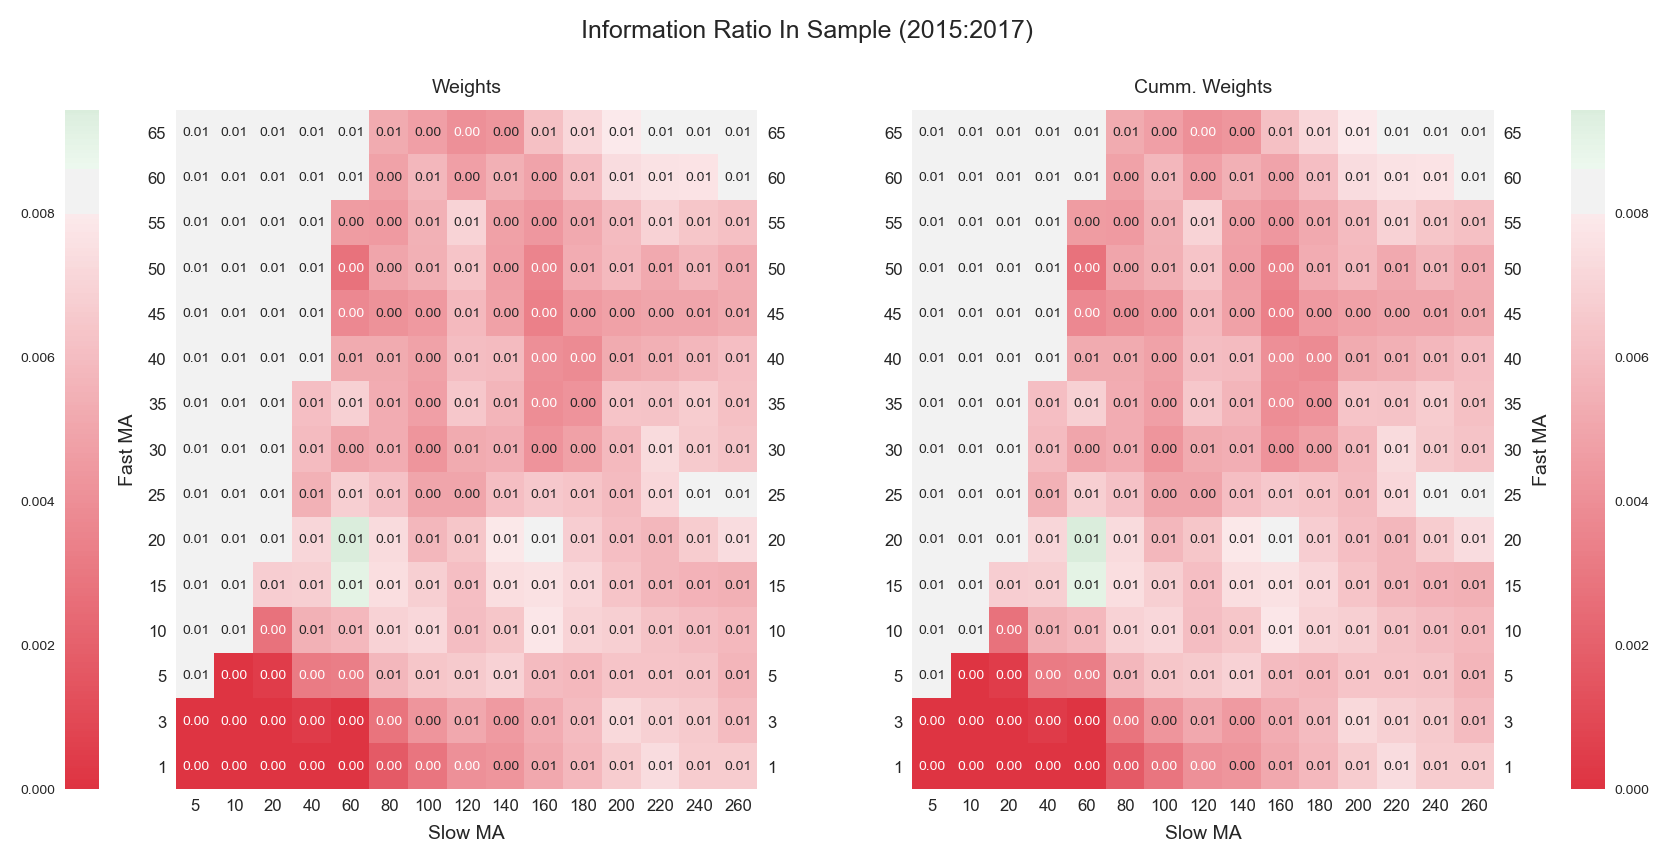

OOS performance:
Strategy: buy_and_hold()
Period: 2018-01-02 to 2018-12-31
	Overall return of SP500: -6.24 %. IR of SP500: -0.37
	Overall return of strategy: -6.24 %. IR strategy: -0.37
Best In-sample performance: 
Strategy: buy_and_hold()
Period: 2016-01-04 to 2018-12-31
	Overall return of SP500: +22.65 %. IR of SP500: 0.54
	Overall return of strategy: +22.65 %. IR strategy: 0.54


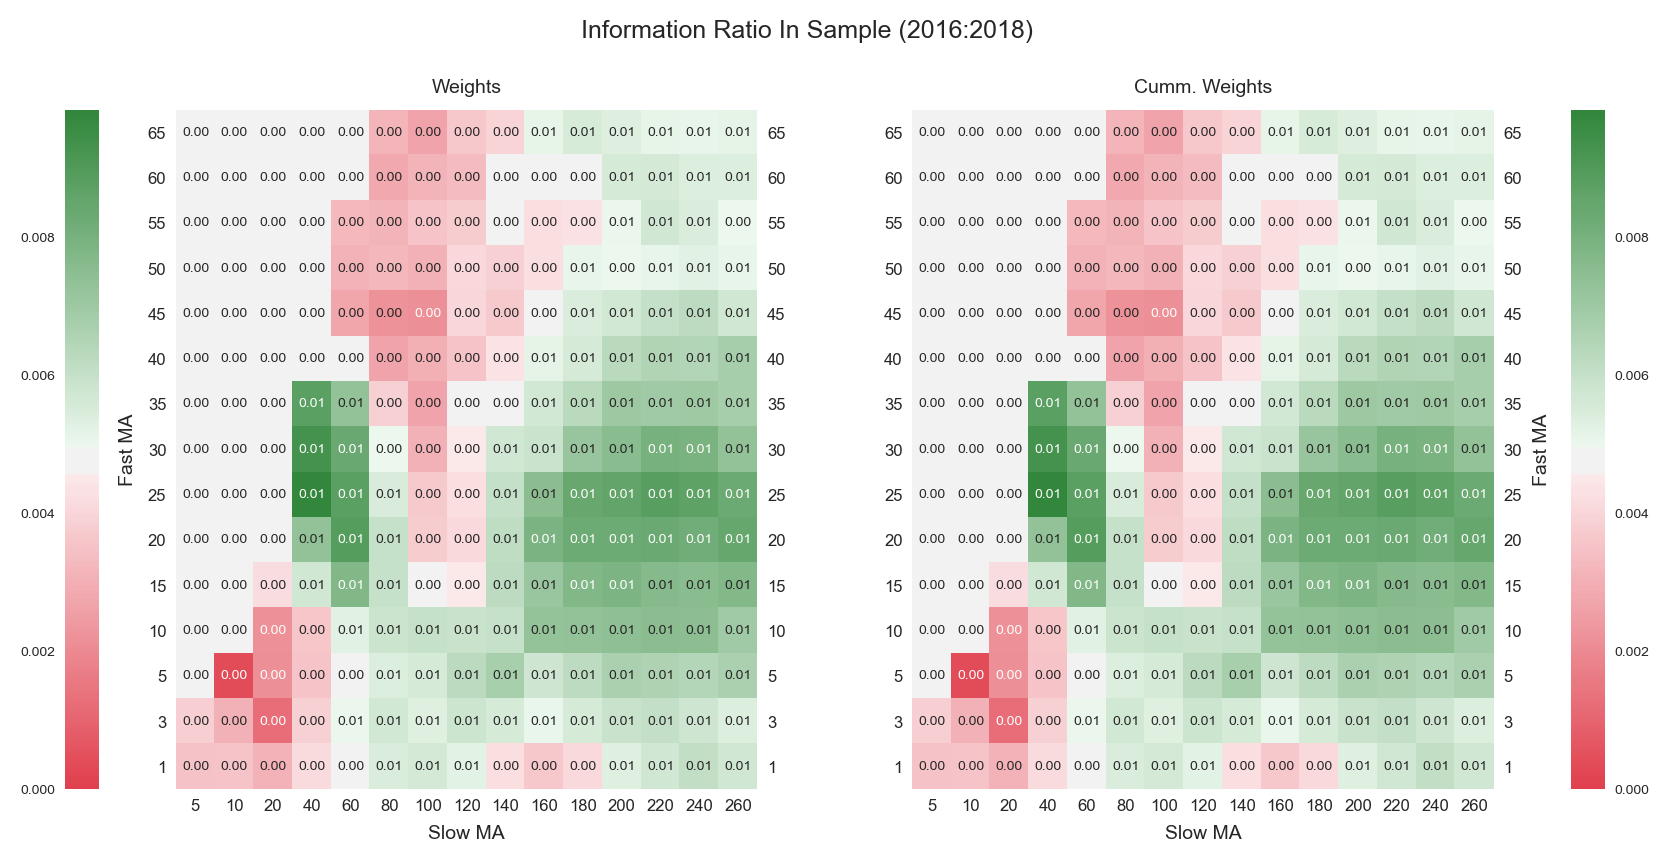

OOS performance:
Strategy: buy_and_hold()
Period: 2019-01-02 to 2019-12-31
	Overall return of SP500: +28.88 %. IR of SP500: 2.32
	Overall return of strategy: +28.88 %. IR strategy: 2.32

End of Walk Forward Optimization


In [10]:
%run Functions.ipynb
hide = True

df_wf = data[IS_start[0]:OOS_end[-1]].copy()
#df_walk_forward = df_walk_forward.loc[:'2020-05-02']

if hide == True:
    # Copy data and create necessary columns 
    new_cols = ['Strat_daily_ret', 'Strat_position', 'Long_only', 'Costs', 'Market_cum_ret']

    df_wf= df_wf.reindex(columns = df_wf.columns.tolist() + new_cols)

    last_position = 0 # We suppose that we start not being invested. 1:long, -1:short

    indiv_ir_list = []
    robust_ir_list = []
    market_ir_list = []

    weights_list = []
    weights_list.append(np.zeros((len(fast_ma_list),len(slow_ma_list))))

    cummulated_weights_list = []

    fast_ma_best_list = []
    slow_ma_best_list = []

    print(info_wf_str)
    
for i in trange(len(IS_start), desc='Walk Forward loop:'):    
    #print(f'{IS_start[i].year} to {IS_end[i].year}')
    
    is_period = df_wf.loc[IS_start[i]:IS_end[i]].copy()
    oos_period = df_wf.loc[OOS_start[i]:OOS_end[i]].copy()
    
    ############################################ IN SAMPLE  ############################################
    strat_pnl_matrix, strats_ir_matrix, market_pnl, market_ir = run_all_combinations_ma_crossover(is_period, fast_ma_list, slow_ma_list, last_position)
    indiv_ir_list.append(strats_ir_matrix)
    market_ir_list.append(market_ir)
    
    # Get the best combination the In-Sample period, or buy_and_hold if it performed better
    best, robust_strats_ir_matrix, IS_weights = get_best_combination_with_memory(strats_ir_matrix, 
                                                                                weights_list, memory_len, 
                                                                                market_ir, num_neighbors_matrix,
                                                                                fast_ma_list, slow_ma_list)
        
    robust_ir_list.append(robust_strats_ir_matrix)
    weights_list.append(IS_weights)
    cummulated_weights_list.append(np.sum(weights_list[-(memory_len+1):], axis=0))
    
#    print("\tParams: {} {}" .format(best['param1'], best['param2']))
    fast_ma_best_list.append(best['param1'])
    slow_ma_best_list.append(best['param2'])
    
    print("Best In-sample performance: ")
    if hide == True:
        print_backtest_stats(is_period, strat_pnl_matrix[best['param1_index'], best['param2_index']], 
                               strats_ir_matrix[best['param1_index'], best['param2_index']], market_pnl, market_ir,
                             strat_params=(best['param1'], best['param2']))
        show_both_heatmaps_new(IS_weights, cummulated_weights_list[i], market_ir, plot_title=str(IS_start[i].year)+":"+str(IS_end[i].year), 
                            x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list,
                              left_plot_title="Weights", right_plot_title="Cumm. Weights")
        
        plt.show()
        hide = True

    ############################################ OUT OF SAMPLE  ############################################
    print("OOS performance:")
    if hide == True:
        strategy = ma_crossover(oos_period, best['param1'], best['param2'])
        oos_period, last_position, strat_pnl, strat_ir, market_pnl, market_ir = backtest_strat(oos_period, strategy, previous_position=last_position)
        print_backtest_stats(oos_period, strat_pnl, strat_ir, market_pnl, market_ir, strat_params=(best['param1'], best['param2']))

        # Save come columns from OOS
        df_wf.loc[OOS_start[i]:OOS_end[i], new_cols] = oos_period[new_cols]

#    print()
    
# Delete first element from weights_list (it was initialized to 0)
weights_list = weights_list[1:]

print("End of Walk Forward Optimization")

Close  Market_daily_ret  Strat_daily_ret  Strat_position    Costs  Long_only  Market_cum_ret  Strat_cum_ret
Date                                                                                                                         
2018-01-02  2695.810059          0.008303         0.008191             1.0  0.29821        1.0     2695.810059    2695.509372
2019-12-30  3221.290039         -0.005781        -0.005781             1.0  0.00000        0.0     3221.290039    2890.489960
2019-12-31  3230.780029          0.002946         0.002946             1.0  0.00000        0.0     3230.780029    2899.005406

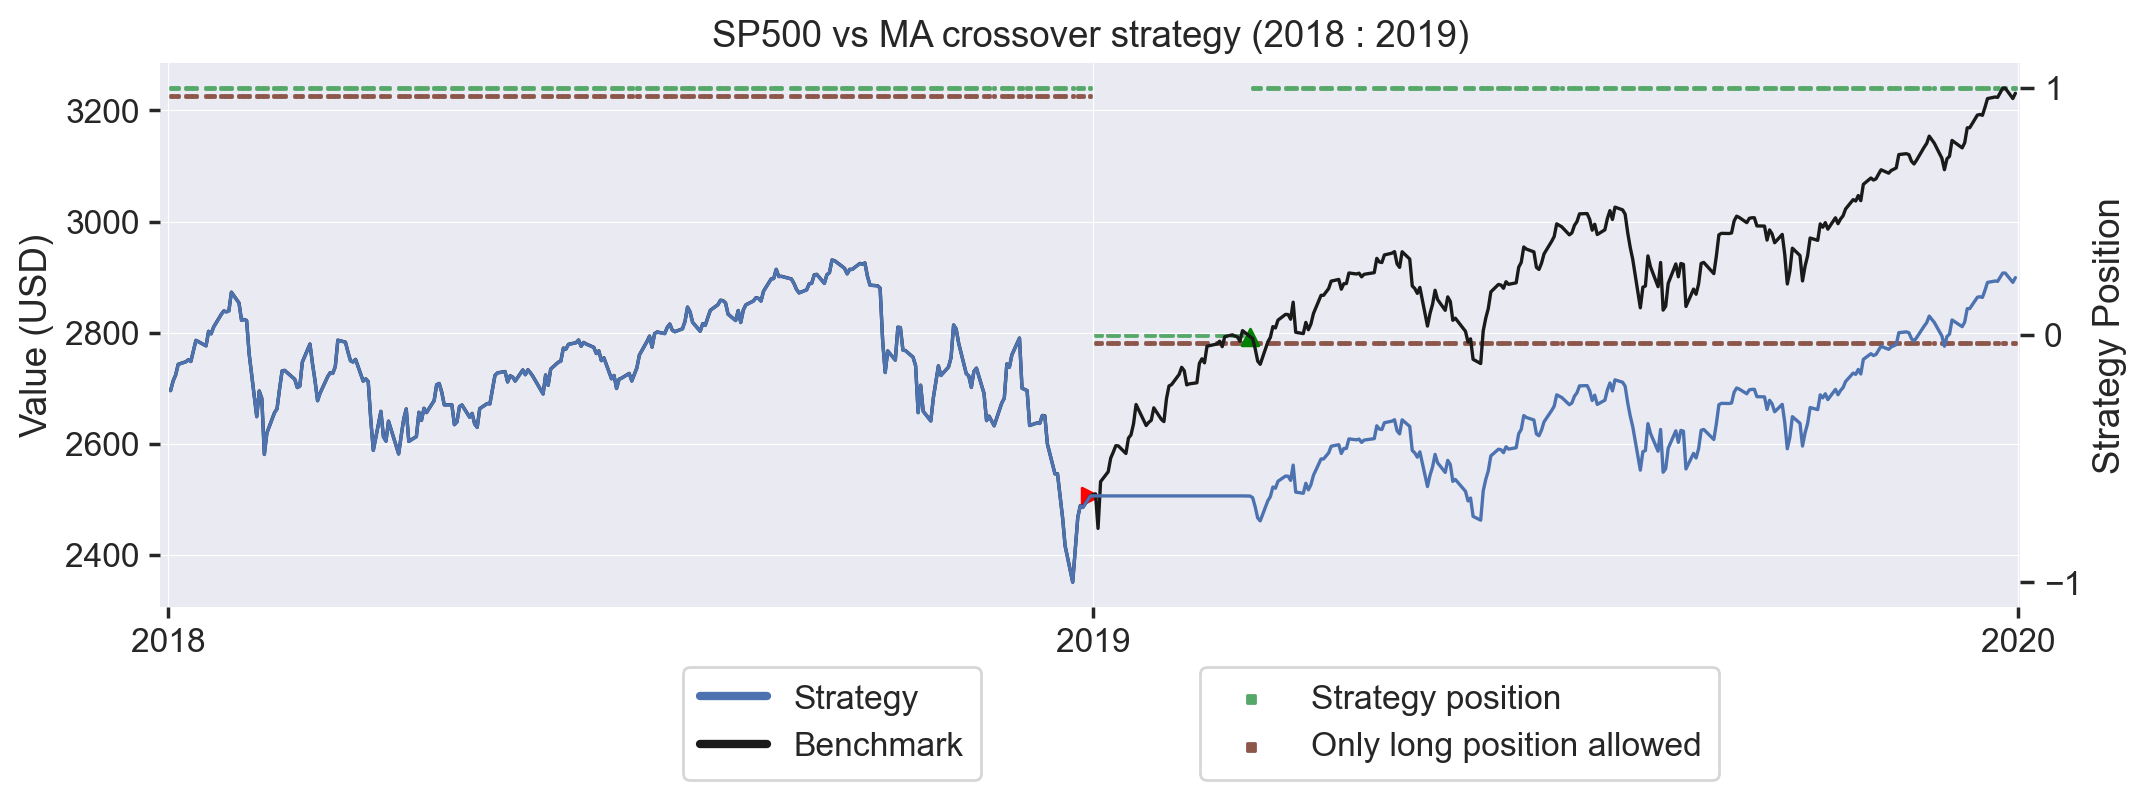

In [14]:
%run Functions.ipynb
ini_mon = df_wf[str(OOS_start[0].year-1)].iloc[-1]['Close']
#ini_mon = 100
results_df = prepare_oos_df(df_wf.loc[OOS_start[0]:OOS_end[-1]].copy(), ini_equity=ini_mon)
results_df.iloc[[0,-2,-1]]
show_oos_plot(results_df, with_legend=True, with_signals=True)
#plt.show()
#results_df['Costs'].cumsum().plot();

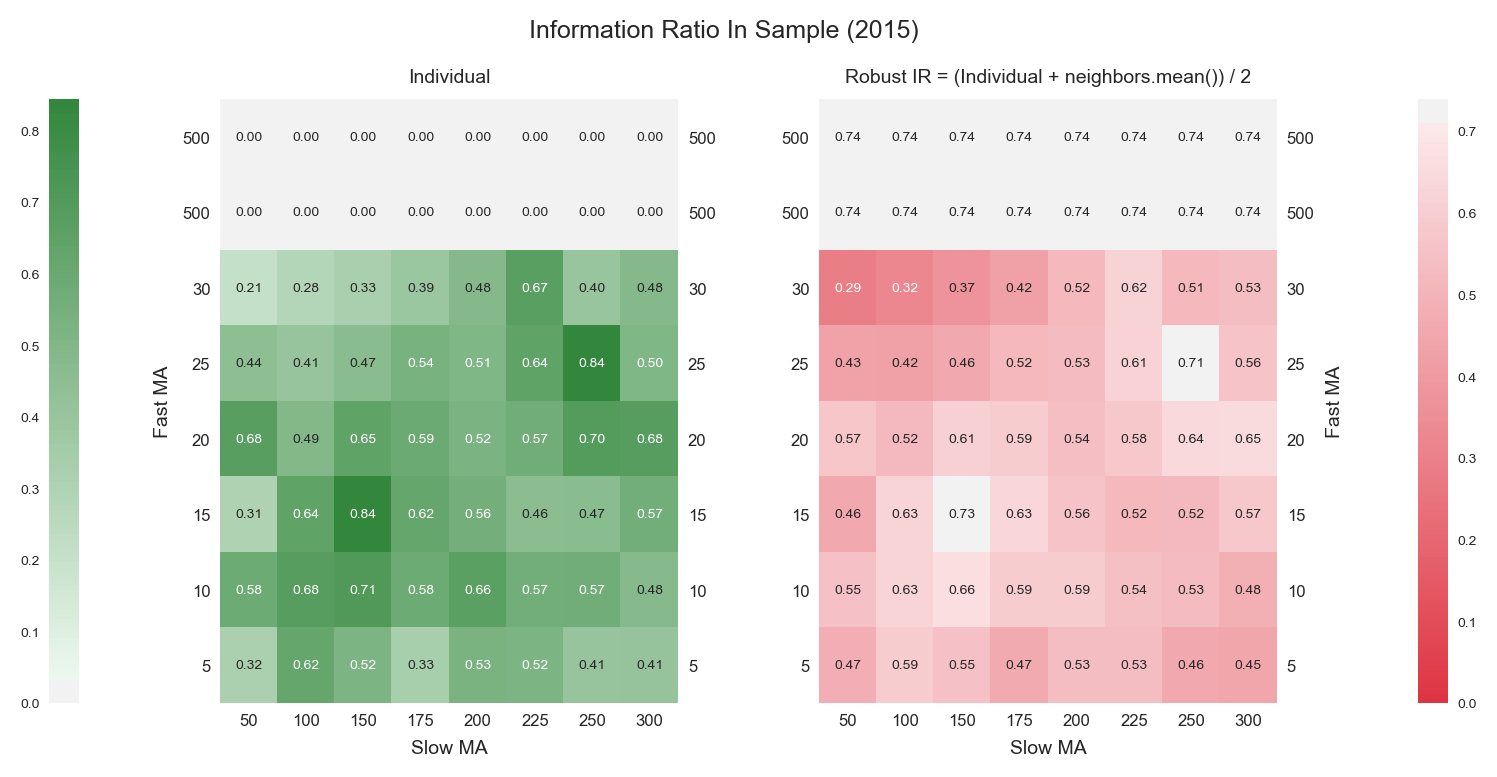

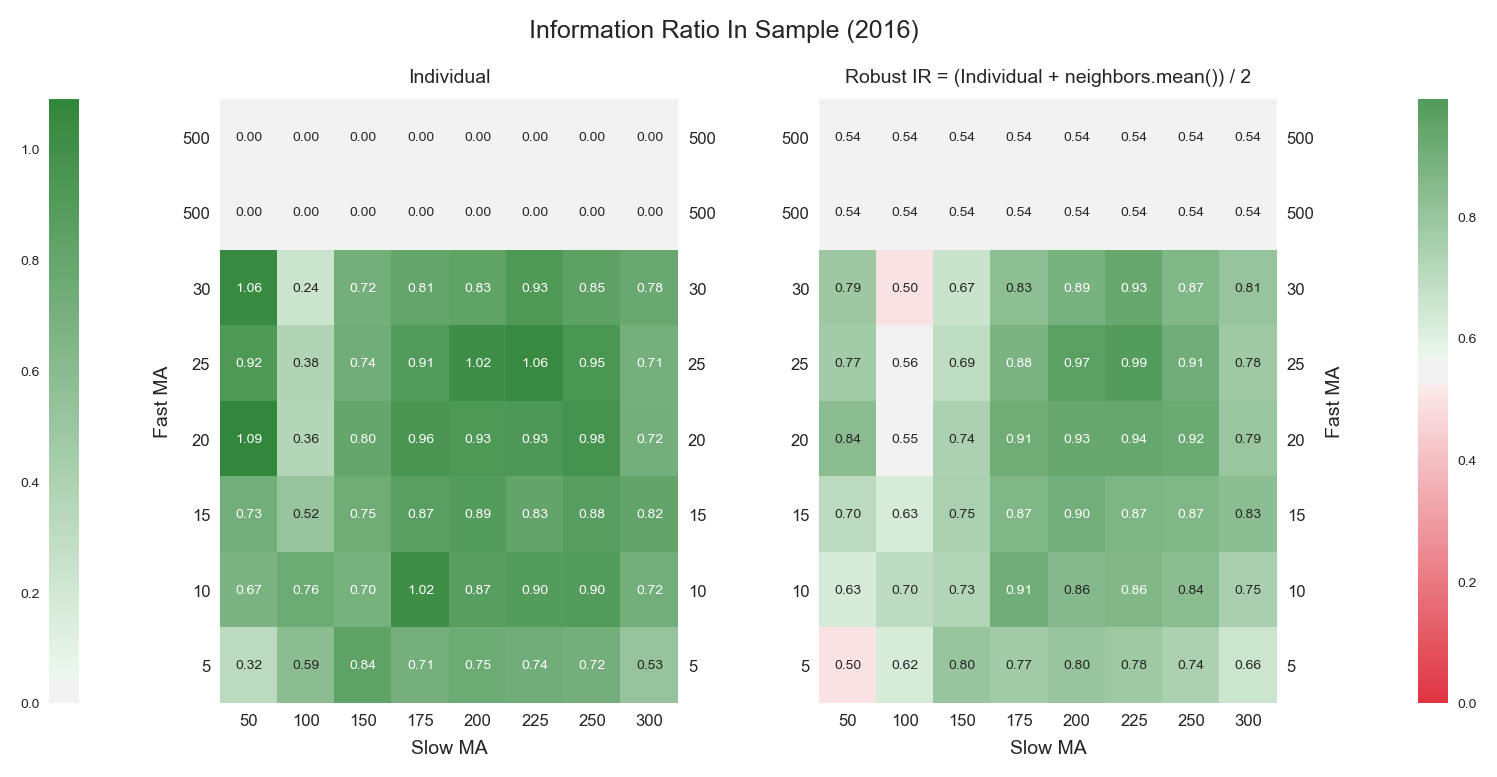

In [15]:
for y in IS_start.year:
    i = y - IS_start.year[0]
    show_both_heatmaps(indiv_ir_list[i], robust_ir_list[i], market_ir_list[i], plot_title=str(y), x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)    

In [11]:
%run Functions.ipynb
from ipywidgets import widgets

options = [year for year in IS_start.year]

selection_slider = widgets.SelectionSlider(
    options=options,
    description='Starting IS year',
    orientation='horizontal',
    layout={'width': '900px'},
)
#selection_slider

def plot_heatmap(year):
    index = year - IS_start.year[0]
    show_both_heatmaps(indiv_ir_list[index], robust_ir_list[index], market_ir_list[index], plot_title=str(year), x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)    
    
widgets.interact(
    plot_heatmap,
    year=selection_slider
);

interactive(children=(SelectionSlider(description='Starting IS year', layout=Layout(width='900px'), options=(2…

## Calculate performance metrics

Initial invested capital = 2673.61


Strat_cum_ret  Market_cum_ret
Date                                     
2018-01-02    2695.509372     2695.810059
2018-01-03    2712.757448     2713.060059
2019-12-30    2890.489960     3221.290039
2019-12-31    2899.005406     3230.780029

AbsRet     ARC      IR      aSD       MD      AMD     MLD    IR**  All Risk   ARCMD  ARCAMD  Num Trades  Out of market
MA Crossover   8.4304  4.1383  0.2885  14.3444  19.7782  13.3072  1.2758  0.0604    0.4817  0.2092  0.3110           3             42
Buy and Hold  20.8396  9.9478  0.6653  14.9513  19.7782  13.3072  0.5859  0.3346    0.2306  0.5030  0.7475           1              0

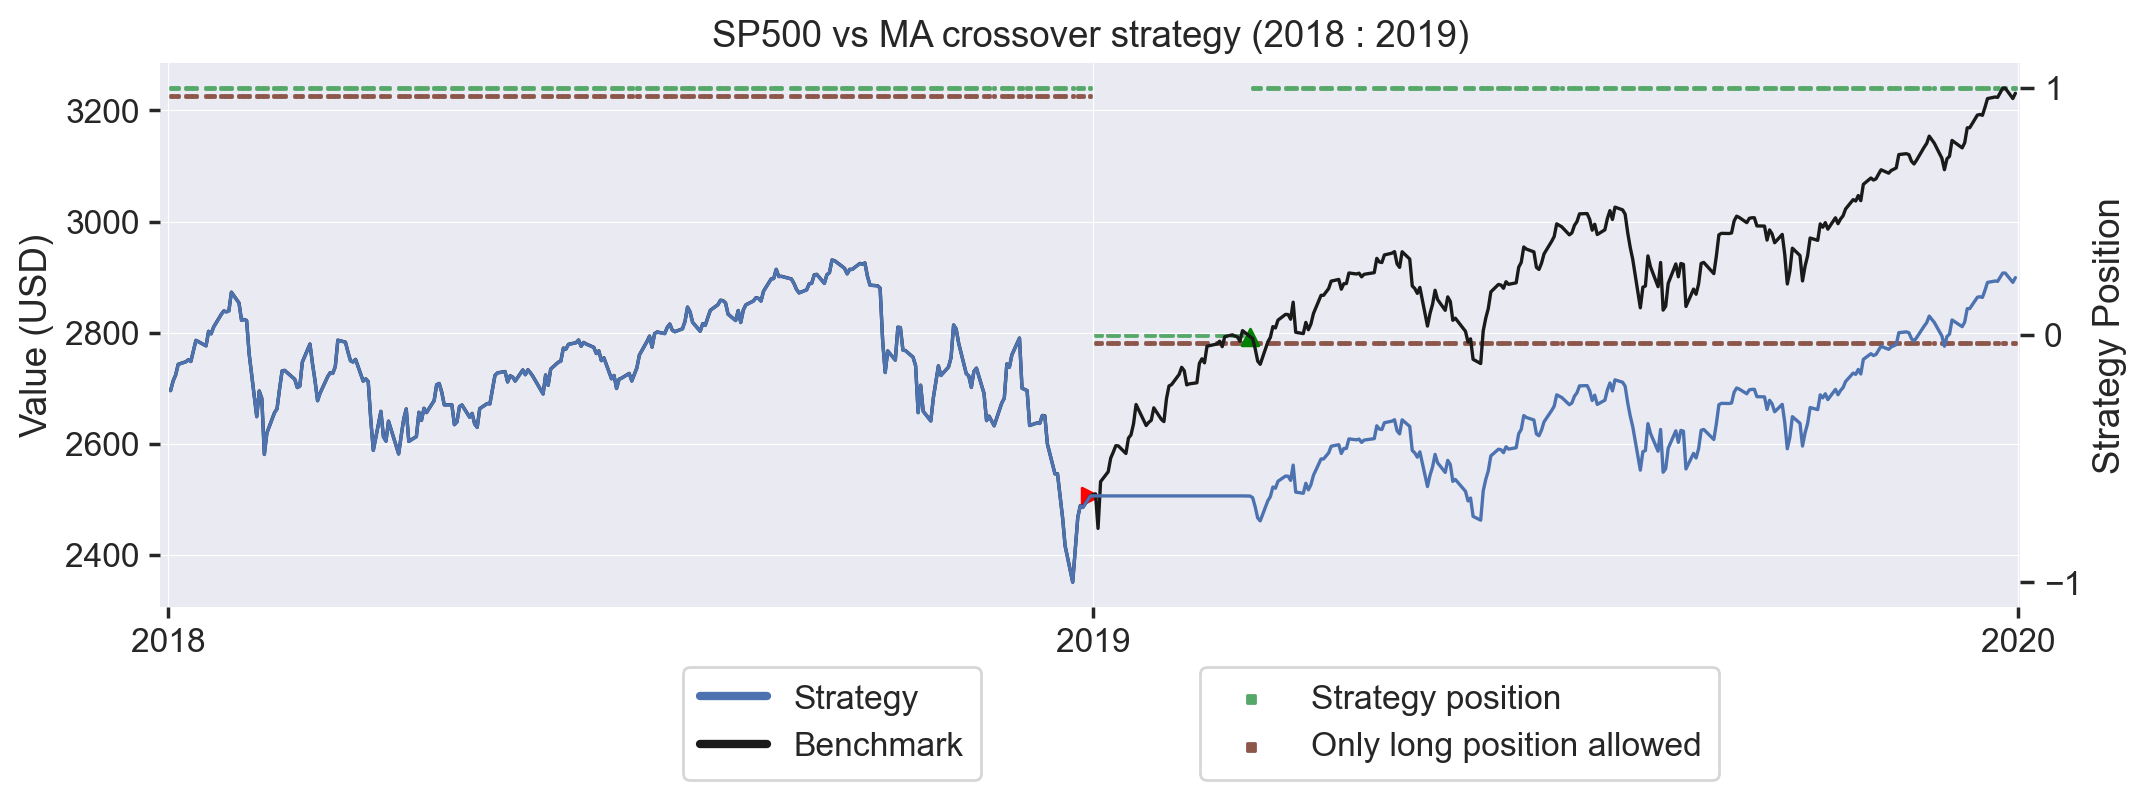

In [17]:
%run Functions.ipynb
print("Initial invested capital = {:.2f}".format(ini_mon))
results_df[['Strat_cum_ret', 'Market_cum_ret']].iloc[[0,1,-2,-1]]

metrics = calculate_performance_metrics(results_df, strat_name='MA Crossover')
metrics
show_oos_plot(results_df, with_legend=True, with_signals=True)

## Save results

After the walk-forward optimization we save the results. The most important column is 'Strat_position'. From it, we can obtain daily and cummulative returns of the strategy.

In [18]:
filename = "Test_results_ma.csv"
#results_df.to_csv("data/{}".format(filename))

if filename not in os.listdir("data"):
    results_df.to_csv("data/{}".format(filename))
    print("File saved properly")
else:
    print("File already exists")
    

File already exists
